# Data Cleaning | NLP Classification

## The problem

Following a data-centric approach, the quality of the machine learning (ML) model is highly dependent on the quality of the data used to train it. Unfortunately, despite curators best efforts, the provided data can still include errors or miss-classifications. It is a well-known issue that data scientists spend more than half their time cleaning the data. One challenge for using a dataset is that there is no "go-to" method of finding errors in the dataset, such as faulty labels or samples that do not fit the business use case.

## The solution: Coresets

Coresets refer to a sampling methodology originating in computational geometry used to approximate optimization problems. They are based on selecting a subset of the original dataset that maintains the entire dataset's statistical properties (including the corner cases). Training a model on the Coreset should give the same result as training it on the full dataset.

When computing a Coreset, every instance in the dataset is assigned an importance value, which indicates how important it is to the final ML model. Samples that receive a high importance value in the Coreset computation require the attention of the data scientist as they usually indicate a labeling error or other data-related issues. Therefore, leveraging the Coresets, we can easily assign an importance score to each sample. Instances with high importance scores have a high probability of being mislabeled. Thus, we can sample instances of interest by looking at the top percentile of importance.

In the end, by speeding up the cleaning process of the dataset, the data scientists can focus on bringing real value and not on curating tasks.

# The goal of this notebook

We will use the Ag News NLP dataset to compute the importance values of all the samples within a class of interest using the coreset logistic regression service. With the help of the important values, we will quickly find samples that are hard to predict or might be mislabeled. Thus, accelerating the cleaning process of the dataset.

We preprocessed the text into embedding using a pretrained Bert model. By doing this, we can successfully run a logistic regression coresets service on top of the resulting embeddings.

# Import Dependencies

In [4]:

import json
import os
import time
import tkinter as tk
from collections import defaultdict
from pathlib import Path
from typing import Optional
from typing import Tuple

import gdown
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.figure import Figure
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegressionCV

In [5]:
# Import the logistic regression Coreset service, which we will use to find important samples within the dataset.
from dataheroes import CoresetTreeServiceLG

In [6]:
# Ignore convergence warnings for logistic regression.
import warnings

warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

In [7]:
# Set a random seed for reproducability.
np.random.seed(42)

# Define Constants

These values are used throughout the notebook for various I/O operations.

In [8]:
# Folder identifier on Google Drive
AG_NEWS_FILE_ID = '1INdDvHDSofByGIqpd7oEwhgYZRsPBFtn'

# Location of the preprocessed ag news dataset.
DATA_DIR = Path("data/ag_news")

# Location of the saved results
DATA_OUTPUT = Path("output")

# The number of top-importance samples that we will pick. 
TOP_N_SAMPLES = 150

# The number of top-importance samples that we will view every iteration.
TOP_N_SAMPLES_VIEWED = 500

# The number of bottom importance samples that we will pick.
BOTTOM_N_SAMPLES = 150

# Legend used to map the class ids to their name.
DATASET_LEGEND = {
    0: "World",
    1: "Sports",
    2: "Business",
    3: "Sci/Tech"
}

# Helper methods

In [8]:
def build_service(X: np.ndarray, y: np.array) -> CoresetTreeServiceLG:
    """
    Generate a new coreset from the given features and labels using the CoresetTreeServiceLG class.
    :param X: A numpy array containing the features used to generate the coreset
    :param y: A numpy array containing the corresponding label for each feature

    :return:
    A CoresetTreeServiceLG object composed of 5% of the input data
    """
    coreset_size = int(0.05 * len(X))
    start_service_time = time.time()
    service = CoresetTreeServiceLG(coreset_size=coreset_size, optimized_for='cleaning', n_instances=len(y))
    service.build(X, y)
    end_service_time = time.time()
    print(f"..Coreset computed in {end_service_time - start_service_time:.2f} seconds...")
    return service


def update_service(service: CoresetTreeServiceLG, cleaned_targets: dict) -> CoresetTreeServiceLG:
    """
     Update an existing CoresetTreeServiceLG object by changing target labels or removing data samples
     based on the changes specified in the cleaned_targets dictionary.
    :param service: A CoresetTreeServiceLG object representing the logistic regression model
    :param cleaned_targets: A dictionary containing the changes to be made. The dictionary has two keys:
        'change_index': A dictionary where the keys are the class IDs and the values are lists of sample indices to be changed.
        If a sample index appears in more than one list, its target label will be changed to the last value it appears in
        the dictionary.
        'drop': A list of sample indices to be removed from the coreset.

    :return:
    The updated CoresetService object.
    """

    # Change target values
    for target_class_id, sample_indices_to_change in cleaned_targets['change_index'].items():
        if len(sample_indices_to_change):
            target_class_ids = [target_class_id] * len(sample_indices_to_change)
            service.update_targets(sample_indices_to_change, target_class_ids)

    # Drop samples
    if len(cleaned_targets['drop']):
        service.remove_samples(cleaned_targets['drop'])

    print('..Finished updating service...')
    return service


def get_top_important_samples(service: CoresetTreeServiceLG,
                              of_interest_class_id: int = 0,
                              top_n_samples: int = 500) -> Tuple[np.array, np.array]:
    """
    Extract the top N important samples for a given class from a CoresetTreeServiceLG object.
    The function returns a tuple containing the indices and the importance
    values of these samples.
    :param service: A CoresetTreeServiceLG object representing the logistic regression model
    :param of_interest_class_id: An integer representing the class ID of interest. The default value is 0.
    :param top_n_samples: An integer representing the number of top important samples to retrieve. The default value is 500.

    :return:
    A tuple containing the indices and the importance values of the top N important samples.
    """

    result = service.get_cleaning_samples(
        class_size={of_interest_class_id: "all"}
    )
    important_sample_indices, important_sample_values = result["idx"][:top_n_samples], result["importance"][:top_n_samples]
    return important_sample_indices, important_sample_values


def cross_val(X: np.ndarray, y: np.array, sample_weight: Optional[np.ndarray] = None,
              kfolds: int = 5, scoring: str = 'roc_auc') -> dict:
    """
    Perform k-fold cross-validation on a logistic regression model.
    The funtion takes feature matrix X, target variable y, the number of folds,
    and the type of scoring as input. It returns a dictionary of the scores for each class.
    :param X: A numpy ndarray representing the feature matrix
    :param y: A numpy array representing the target variable
    :param sample_weight: A numpy array representing the weights of the samples
    :param kfolds: An integer representing the number of folds for cross-validation. The default value is 5
    :param scoring: A string representing the scoring metric to use for evaluation. The default is 'roc_auc'

    :return:
    The function returns a dictionary of the scores for each class.
    """
    clf = LogisticRegressionCV(
        cv=kfolds,
        random_state=42,
        scoring=scoring,
        multi_class="ovr",
        max_iter=5000,
        class_weight="balanced",
        refit=True,
    ).fit(X, y, sample_weight)

    scores = dict()
    for class_id, class_scores in clf.scores_.items():
        class_score = class_scores.mean(axis=0).max()
        scores[class_id] = class_score

    print(f'..Finished evaluating LG performance using {scoring}...')
    return scores


def aggregate_scores(per_class_scores: dict, aggregated_scores: dict) -> dict:
    """
    Aggregate the per-class scores by appending the scores for each class to the corresponding
    list of aggregated scores. The function returns the updated dictionary of aggregated scores.
    :param per_class_scores: A dictionary containing per-class scores. The keys are class IDs and the values are lists of scores
    :param aggregated_scores: A dictionary containing aggregated scores. The keys are class IDs and the values are lists of scores

    :return:
    The updated dictionary of aggregated scores
    """
    for class_id, scores in per_class_scores.items():
        aggregated_scores[class_id].append(
            per_class_scores[class_id]
        )

    return aggregated_scores

# Load data

## How We Computed the Embeddings 👇


The features we will load are already precomputed within a different script. These were computed from the Ag News dataset with the following steps.
1. We initialized a pretrained Bert classifier. We dropped the last classification layer to output an embedding instead of the class distribution.
2. We passed all the text through the Bert model, which outputs a 768 embedding.

**NOTE:** We moved these steps to a different script because it takes a few hours to run. Also, you need a GPU and extra dependencies to run it properly. Thus we wanted to make this notebook as light as possible.

The raw dataset represents the actual/raw text used as input to the NLP Bert model.

## Load data

The data you need for this notebook is placed here.
We will download the contents of a folder called AG_News and place the data at data/ag_news.
The folder contains three files.
- raw_train.npy: Raw text data
- x_train.npy: Text embeddings of every sample
- y_train.npy: Labels for every sample

The folder size exceeds 1GB, the download may take few minutes.

In [17]:
def download_data():
    """Utility function used to unzip the download AGNEWS.zip file."""
    print("Downloading files...")
    gdown.download_folder(f"https://drive.google.com/drive/folders/{AG_NEWS_FILE_ID}",
                          output=str(DATA_DIR), use_cookies=False, quiet=False)


download_data()

Retrieving folder list


Processing file 19pnD2o1BPO8LGpu6PCuL9FqcqxDNc66Y raw_train.npy
Processing file 1PAym7GddBBRKOCrY1IGGNrYfhMvQMmsJ x_train.npy
Processing file 1PFeQPyEyZe6E0PVHcT069_HgQDr57A93 y_train.npy
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=19pnD2o1BPO8LGpu6PCuL9FqcqxDNc66Y
To: /Users/luchicla/Work/Consulting/CoreAI/Data_Heroes/src/nlp/data/ag_news/raw_train.npy
100%|██████████| 405M/405M [00:35<00:00, 11.2MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1PAym7GddBBRKOCrY1IGGNrYfhMvQMmsJ
To: /Users/luchicla/Work/Consulting/CoreAI/Data_Heroes/src/nlp/data/ag_news/x_train.npy
100%|██████████| 614M/614M [00:55<00:00, 11.2MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1PFeQPyEyZe6E0PVHcT069_HgQDr57A93
To: /Users/luchicla/Work/Consulting/CoreAI/Data_Heroes/src/nlp/data/ag_news/y_train.npy
100%|██████████| 800k/800k [00:00<00:00, 4.89MB/s]
Download completed


In [18]:
raw_data = np.load(os.path.join(DATA_DIR, "raw_train.npy"))
X = np.load(os.path.join(DATA_DIR, "x_train.npy"))
y = np.load(os.path.join(DATA_DIR, "y_train.npy"))

print(f"Loaded X - shape = {X.shape}")
print(f"Loaded y - shape = {y.shape}")

Loaded X - shape = (100000, 768)
Loaded y - shape = (100000,)


## Visualise the original samples distribution

Text(0, 0.5, 'Counts')

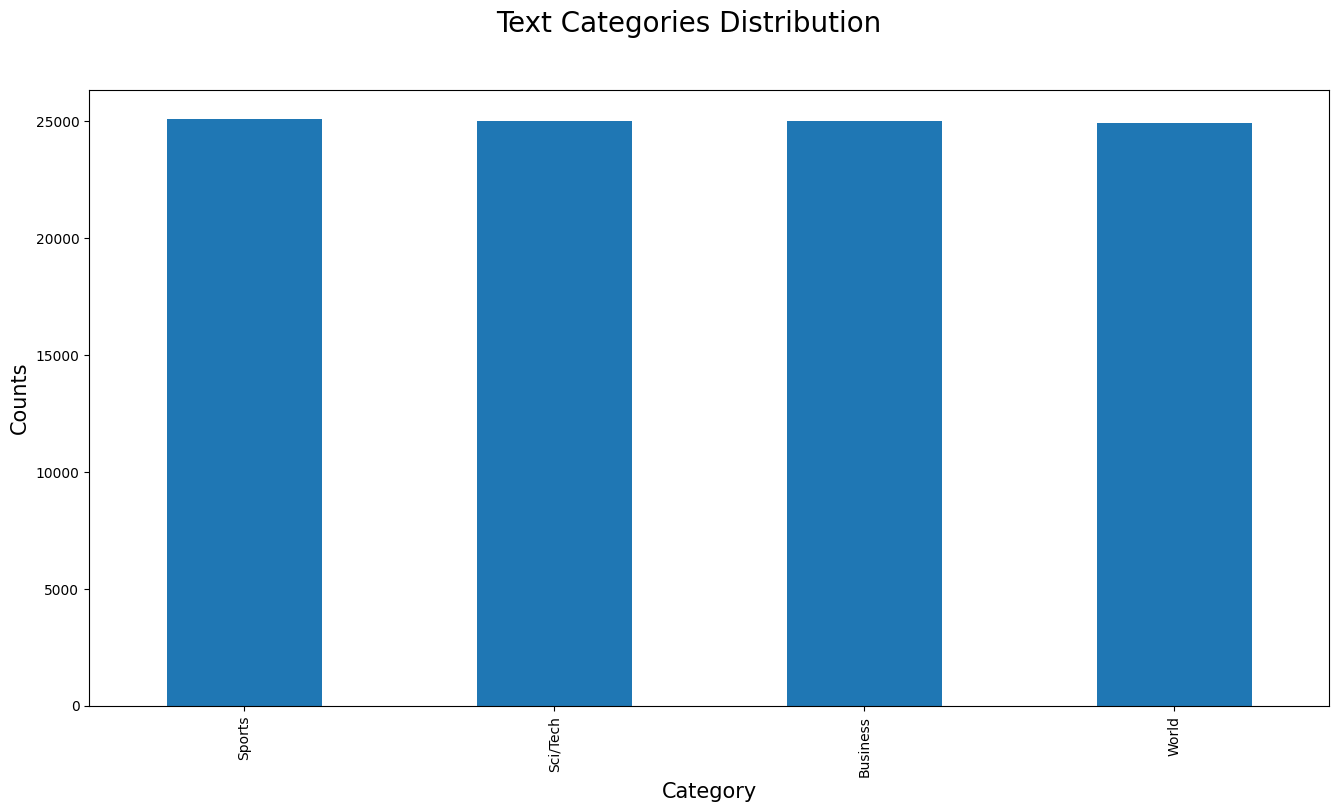

In [10]:
fig, ax = plt.subplots(figsize=(16, 8))
labels_distribution = pd.Series(y).value_counts()
labels_distribution.index = [DATASET_LEGEND[class_id] for class_id in labels_distribution.index]
labels_distribution.plot.bar()
fig.suptitle("Text Categories Distribution", fontsize=20)
ax.set_xlabel("Category", fontsize=15)
ax.set_ylabel("Counts", fontsize=15)

## Pick the class of interest

In [11]:
# of_interest_class_id = np.argmin(auc_scores)
of_interest_class_id = 0

# Map the id its name.
of_interest_class_name = DATASET_LEGEND[of_interest_class_id]

print(f"Our class of interest is '{of_interest_class_name}'.")
print(f"It has a total of {labels_distribution[of_interest_class_name]} samples/text entries.")

Our class of interest is 'World'.
It has a total of 24900 samples/text entries.


# Compute the Importance Using Coresets

With the help of the `CoresetServiceLG` class, we will find the samples of interest within the `of_interest_continuous_class_id` class. This service will compute the coreset relative to the given data and logistic regression. Using the coreset, it can assign importance values with the help of which we will find our samples of interest.

In [12]:
# Compute the coreset size as 5% of all the data
coreset_size = int(0.05 * len(X))
print(f"Coreset size {coreset_size} samples.")

# Build coreset
start_service_time = time.time()
service = CoresetTreeServiceLG(coreset_size=coreset_size, optimized_for='cleaning', n_instances=len(y))
service.build(X, y)
end_service_time = time.time()

print(f"Coreset computed in {end_service_time - start_service_time:.2f} seconds")

Coreset size 5000 samples.
Coreset computed in 22.73 seconds


## Visualise samples importance

In [13]:
important_samples = service.get_cleaning_samples(class_size={of_interest_class_id: 50_000})
important_sample_indices, important_sample_values = important_samples["idx"], important_samples["importance"]

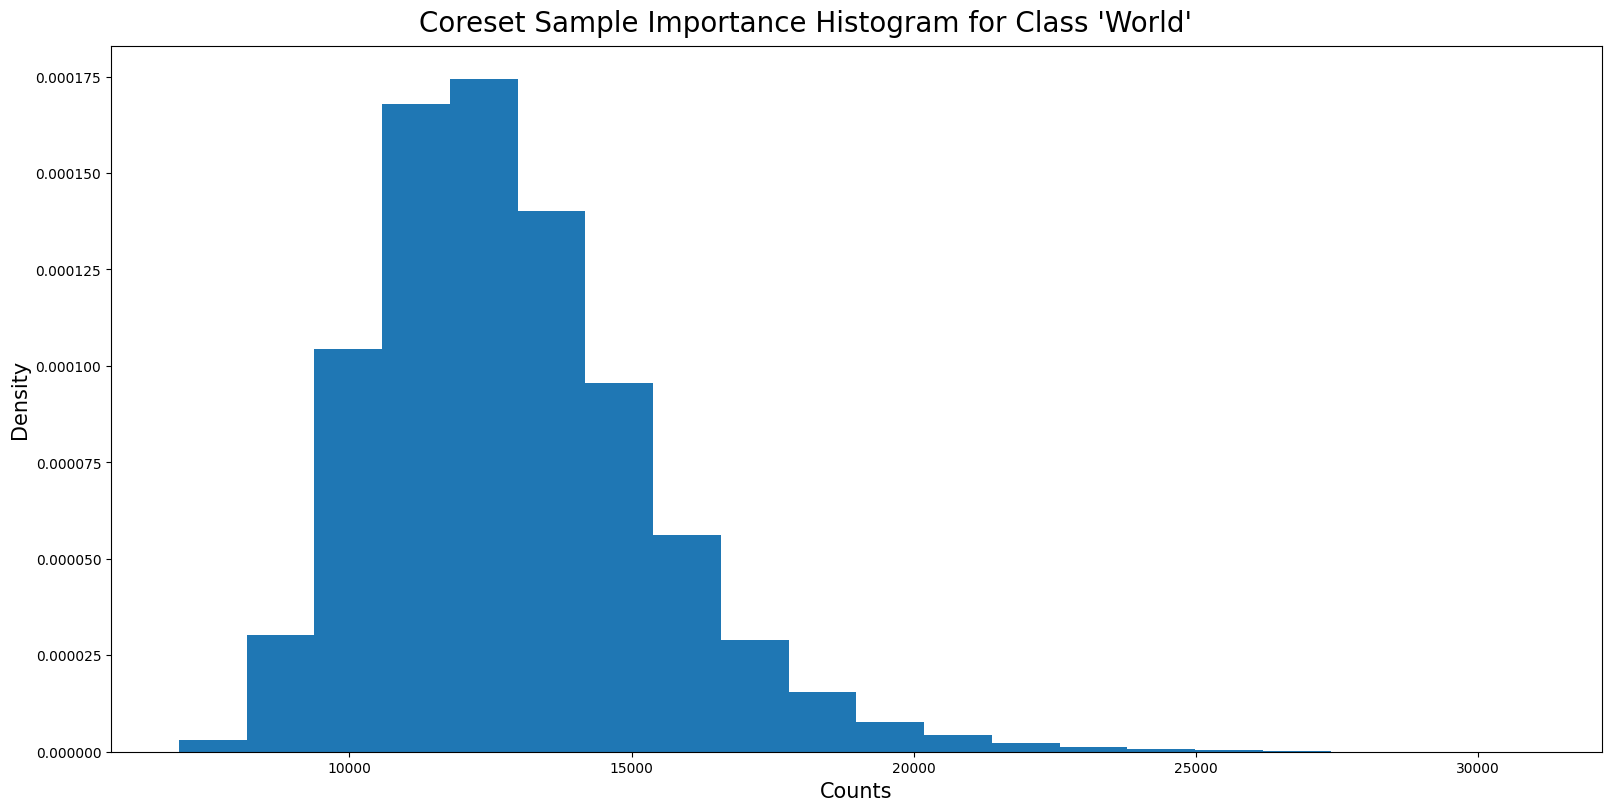

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8), constrained_layout=True)
fig.suptitle(f"Coreset Sample Importance Histogram for Class '{of_interest_class_name}'", fontsize=20)
ax.set_xlabel("Counts", fontsize=15)
ax.set_ylabel("Density", fontsize=15)

plt.hist(
    important_sample_values,
    bins=20,
    density=True,
);

# Visualise Samples Sorted By Importance

We will visualize the data samples from the top and bottom ends of the importance spectrum based on what we computed using the coresets service.

One important thing to highlight is that the indices and values returned by the coreset service are already sorted in descending order.

## Define Visualisation Functions


In [18]:
class bcolors:
    """Class that aggregates typing constants."""

    HEADER = '\033[95m'
    BOLD = '\033[1m'
    ENDC = '\033[0m'


def visualize(raw_train: np.ndarray, y_train: np.ndarray, importance_values: np.ndarray, sample_indices: np.array, title: str):
    """Generator used to visualize the samples and annotations within the Ag News dataset."""

    print(f"{bcolors.HEADER}{'*' * 40} {title} {'*' * 40}{bcolors.ENDC}")

    num_sections = len(raw_train) // 5 + 1
    chunks_raw_train = np.array_split(raw_train, num_sections)
    chunks_y_train = np.array_split(y_train, num_sections)
    chunks_importance_values = np.array_split(importance_values, num_sections)
    chunks_sample_indices = np.array_split(sample_indices, num_sections)
    for chunk_raw_train, chunk_y_train, chunk_importance_values, chunk_sample_indices in zip(chunks_raw_train, chunks_y_train,
                                                                                             chunks_importance_values,
                                                                                             chunks_sample_indices):
        for raw_train, label_id, importance_value, sample_index in zip(chunk_raw_train, chunk_y_train, chunk_importance_values, chunk_sample_indices):
            print(f"{bcolors.BOLD}Text{bcolors.ENDC}: {raw_train}")
            print(f"{bcolors.BOLD}Label Name{bcolors.ENDC}: {DATASET_LEGEND[label_id]}")
            print(f"{bcolors.BOLD}Importance Value{bcolors.ENDC}: {importance_value:.2f}")
            print(f"{bcolors.BOLD}Sample Index{bcolors.ENDC}: {sample_index}")
            print(f"{bcolors.HEADER}{'-' * 100}{bcolors.ENDC}")
        yield


def get_top(important_sample_indices: np.ndarray, important_sample_values: np.ndarray):
    """Utility function that extracts top-importance samples based on the output from the coresets service."""

    top_important_sample_indices = important_sample_indices[:TOP_N_SAMPLES]
    top_important_raw_train = raw_data[top_important_sample_indices]
    top_important_y_train = y[top_important_sample_indices]
    top_importance_values_train = important_sample_values[:TOP_N_SAMPLES]

    return top_important_raw_train, top_important_y_train, top_importance_values_train, top_important_sample_indices


def get_bottom(important_sample_indices: np.ndarray, important_sample_values: np.ndarray):
    """Utility function that extracts bottom-importance samples based on the output from the coresets service."""

    bottom_important_sample_indices = important_sample_indices[-BOTTOM_N_SAMPLES:]
    bottom_important_raw_train = raw_data[bottom_important_sample_indices]
    bottom_important_y_train = y[bottom_important_sample_indices]
    bottom_importance_values = important_sample_values[-BOTTOM_N_SAMPLES:]

    return bottom_important_raw_train, bottom_important_y_train, bottom_importance_values, bottom_important_sample_indices

## Visualise Top Importance

Within the top-importance samples, we will find hard to predict samples or mislabeled samples.

Notice how the top importance samples contain examples that are either mislabeled or samples that should be dropped. In contrast, the
bottom importance samples primarily contain examples that are correctly classified. Based on this observation, we will proceed with
cleaning the data focusing on the top importance samples only.

In [19]:
top_important_raw_train, top_important_y_train, top_importance_values, top_important_sample_indices = get_top(important_sample_indices, important_sample_values)
top_importance_visualizer = visualize(
    raw_train=top_important_raw_train,
    y_train=top_important_y_train,
    importance_values=top_importance_values,
    sample_indices=top_important_sample_indices,
    title="Top Importance"
)

In [20]:
next(top_importance_visualizer)

**************************************** Top Importance ****************************************
Text: Tennis: Sharapova wins finale Maria Sharapova beats Serena Williams 4-6 6-2 6-4 in the Tour Championships final.
Label Name: World
Importance Value: 30986.58
Sample Index: 89787
----------------------------------------------------------------------------------------------------
Text: Massu Defeats Kucera at CA Trophy Olympic champion Nicolas Massu defeated Karol Kucera 6-4, 6-7 (5), 6-4 at the CA Trophy tournament on Tuesday.
Label Name: World
Importance Value: 29009.60
Sample Index: 16061
----------------------------------------------------------------------------------------------------
Text: Incredibles tops Nemo film record Animated film The Incredibles beats Disney/Pixar's previous US box office record for Finding Nemo.
Label Name: World
Importance Value: 27853.08
Sample Index: 61077
-------------------------------------------------------------------------------------------------

The top importance samples contain mostly examples that are mislabeled. As we can see above, four of the five top important samples are sports related
(samples with indices: 89787, 16061, 42447, 90762) while one sample is more related to entartainment or business (sample with index: 61077).

In [21]:
next(top_importance_visualizer)

Text: Kawaguchi out as foreign minister as Koizumi reshuffles cabinet TOKYO - Prime Minister Junichiro Koizumi appointed Nobutaka Machimura to succeed Yoriko Kawaguchi as foreign minister in a cabinet reshuffle Monday, while retaining Chief Cabinet Secretary Hiroyuki Hosoda and Finance Minister Sadakazu Tanigaki.
Label Name: World
Importance Value: 26246.09
Sample Index: 21498
----------------------------------------------------------------------------------------------------
Text: New browser takes on Microsoft Microsoft's popular Internet Explorer has a serious rival in the Firefox browser.
Label Name: World
Importance Value: 26226.59
Sample Index: 22871
----------------------------------------------------------------------------------------------------
Text: Tennis: Henman win in US Open Tim Henman reaches the US Open quarter-finals for the first time after Nicolas Kiefer retires injured.
Label Name: World
Importance Value: 25770.52
Sample Index: 96774
------------------------------

As we move down in the sample importance, we observe that correctly labeled samples are also present. For example, the first sample above. However, the
majority of the top importance samples are still samples incorrectly labeled.

In [27]:
next(top_importance_visualizer)

Text: Schumi storms to Japan win Michael Schumacher wins a record 13th race in a season at the Japanese Grand Prix.
Label Name: World
Importance Value: 25167.29
Sample Index: 48949
----------------------------------------------------------------------------------------------------
Text: Cricket: England outclass Zim England race to a 2-0 series lead with a comfortable 161-run win over Zimbabwe.
Label Name: World
Importance Value: 25140.16
Sample Index: 81248
----------------------------------------------------------------------------------------------------
Text: Jets Turn Miami Miscues Into Third Victory The Jets came up with four turnovers by Dolphins quarterback Jay Fiedler in the second half, including an interception returned 66 yards for a touchdown.
Label Name: World
Importance Value: 25024.44
Sample Index: 50674
----------------------------------------------------------------------------------------------------
Text: Anchor Away Tom Brokaw makes his steady-voiced, flag-waving, 

Visualising some of the top importance samples above clearly shows that mislabelled samples have a larger importance. This behaviour can be exploited to
easily clean up the data.

Moreover, by looking at the top importance samples, we can get a better understanding of the dataset. For example, in the examples above, we see that most of
 the mislabeled "World" samples are "Sports" examples. We can speculate that this error is cause by an automated labelling algorithm which identifies samples
  as "World" if the sample contains a person's name, a country name, a location, or other proper names.

The main idea is that in the top percentile of the high importance samples, we can find mislabeled or interesting samples that help us debug the labels and understand the dataset better.

In [23]:
bottom_important_raw_train, bottom_important_y_train, bottom_importance_values, bottom_important_sample_indices = get_bottom(important_sample_indices,
                                                                                                                             important_sample_values)
bottom_importance_visualizer = visualize(
    raw_train=bottom_important_raw_train,
    y_train=bottom_important_y_train,
    importance_values=bottom_importance_values,
    sample_indices=bottom_important_sample_indices,
    title="Bottom Importance"
)

In [24]:
next(bottom_importance_visualizer)

**************************************** Bottom Importance ****************************************
Text: Australia probes Iraq bomb blast that produced its first &lt;b&gt;...&lt;/b&gt; SYDNEY : An investigation has been ordered into whether the media was tipped off before a car bombing that caused Australia #39;s first casualties in the Iraq conflict, Foreign Minister Alexander Downer said.
Label Name: World
Importance Value: 8371.24
Sample Index: 62627
----------------------------------------------------------------------------------------------------
Text: Kuwait Detains Soldiers for Plot Against U.S. Forces  KUWAIT (Reuters) - Kuwaiti security forces have detained up  to eight Kuwaiti soldiers suspected of plotting to attack U.S.  forces in the Gulf Arab state, a security source said on  Monday.
Label Name: World
Importance Value: 8367.15
Sample Index: 44607
----------------------------------------------------------------------------------------------------
Text: Team of doctors fl

In [25]:
next(bottom_importance_visualizer)

Text: Canada considers fate of suspected NKorean refugees in China &lt;b&gt;...&lt;/b&gt; Canada is facing a diplomatic headache after a group of suspected North Koreans broke into the Canadian Embassy in the Chinese capital, Beijing, on Wednesday.
Label Name: World
Importance Value: 8352.51
Sample Index: 71882
----------------------------------------------------------------------------------------------------
Text: Pakistan Says 'Important' Al Qaeda Men Arrested (Reuters) Reuters - Pakistani security forces have\arrested two "important" al Qaeda operatives, including an\Egyptian, a senior official said on Wednesday.
Label Name: World
Importance Value: 8352.26
Sample Index: 58839
----------------------------------------------------------------------------------------------------
Text: Darfur rebels put forward peace plan at talks in Nigeria : Rebel groups proposed a new peace agreement at talks aimed at restoring calm to Sudan #39;s Darfur region, calling for international peacekeepers

In [26]:
next(bottom_importance_visualizer)

Text: Sharon moves to form new coalition after crushing opponents of &lt;b&gt;...&lt;/b&gt; JERUSALEM (AFP) - Israeli Prime Minister Ariel Sharon moved swiftly to forge a national unity government after winning approval to reshape his coalition and crushing internal opposition to his Gaza pullout plan.
Label Name: World
Importance Value: 8345.47
Sample Index: 35860
----------------------------------------------------------------------------------------------------
Text: Car bomb explodes in Mosul, wounding 5 MOSUL, Iraq -- A car bomb exploded Friday near an American armored vehicle in the northern Iraq city of Mosul, wounding five US soldiers, the military said.
Label Name: World
Importance Value: 8343.28
Sample Index: 56241
----------------------------------------------------------------------------------------------------
Text: Israeli Soldiers Kill Two Gaza Militants (Reuters) Reuters - Israeli soldiers shot and killed two\Palestinian militants near a Jewish settlement in the Gaza\S

In contrast to the top importance samples we previously investigated, the bottom importance samples show only correctly classified samples.

In conclusion, using the DataHeroes Coresets library, we used an innovative way to find instances with potentially faulty labels. Thus, speeding up the process of debugging and understanding your dataset.

After deciding on a class of interest, we used the Coresets logistic regression engine to calculate the important values of our class of interest.

Finally, we rendered the top and bottom percentiles using the sorted samples relative to the importance computed by the coresets. We have found wrongly annotated samples within the top percentile of our samples. While in the bottom percentile, we have seen correctly labeled samples.

# Data cleaning GUI

## Evaluate the model on the original data

In [ ]:
# Dictionary used for storing the results (balanced accuracy, number of viewed samples, number of cleaned samples)
# after every cleaning iteration.
results = {
    'viewed_samples': [0],
    'cleaned_samples': [0],
    'balanced_accuracy': defaultdict(list)
}

# Index for the last current iteration
cleaning_iteration = 0


In [21]:
# Evaluate model on original data
balanced_accuracy = cross_val(X, y, scoring='balanced_accuracy')
results['balanced_accuracy'] = aggregate_scores(balanced_accuracy, results['balanced_accuracy'])
print(f"Raw data balanced accuracy: {balanced_accuracy[of_interest_class_id]:.2f}")

..Finished evaluating LG performance using balanced_accuracy...
Raw data balanced accuracy: 0.87


## Create a GUI to help select which sample labels to change or which samples to drop

## Helper methods for the cleaning GUI

In [22]:
def build_coreset_callback():
    """Rebuild the CoresetTreeServiceLG object using the global X and y data."""
    global service, X, y
    service = build_service(X, y)


def cross_val_callback():
    """
    Use the build_service and cross_val functions to perform cross-validation on the input data and stores the
    evaluation results in a dictionary.

    The function does not take any input parameters explicitly. It uses the following global variables:
        X: A numpy array containing the input feature data.
        y: A numpy array containing the corresponding label data.
        results: A dictionary for storing the evaluation results.

    :return:
        None
    """
    global X, y, results

    score = cross_val(X, y, scoring='balanced_accuracy')
    results['balanced_accuracy'] = aggregate_scores(score, results['balanced_accuracy'])


def top_important_samples_callback():
    """
    Callback function for printing out the top TOP_N_SAMPLES_VIEWED most important samples for a specific class of interest identified
    by of_interest_class_id.

    The function does not take any input parameters explicitly. It uses the following global variables:
        service: A CoresetTreeServiceLG object for generating coreset and performing cross-validation.
        raw_data: A numpy array containing the raw text samples
        of_interest_class_id: An integer representing the class ID of interest
        TOP_N_SAMPLES_VIEWED: An integer representing the number of top important samples to retrieve
        top_important_samples_textarea: A Text TK object

    :return:
        None
    """
    global service, raw_data, of_interest_class_id, TOP_N_SAMPLES_VIEWED, top_important_samples_textarea
    sample_indices = get_top_important_samples(service, of_interest_class_id, TOP_N_SAMPLES_VIEWED)
    if not len(sample_indices[0]):
        print('--Error! No important samples available. Please rebuild coreset...')
        return
    if top_important_samples_textarea.compare("end-1c", "!=", "1.0"):
        top_important_samples_textarea.delete("1.0", tk.END)
    for sample_index in sample_indices[0]:
        # Add some text in the text widget
        current_sample_output = f'{sample_index}: {raw_data[sample_index]}\n******\n'
        top_important_samples_textarea.insert(index=tk.END, chars=current_sample_output)


def clean_samples_callback():
    """
    Callback function for cleaning the dataset based on user-defined changes.

    This function allows the user to make changes to the label and/or drop samples from the dataset. The user can
    specify which samples should be changed to which class and/or dropped from the dataset. The changes are saved to a
    JSON file for later inspection.

    The function updates the `service` object to take into account the latest label changes and dropped samples. The
    `X`, `y`, and `raw_data` arrays are also updated to reflect the changes made by the user.

    Additionally, the number of cleaned and viewed samples is appended to the `results` dictionary for later analysis.

    The function does not take any input parameters explicitly. It uses the following global variables:
        service: A CoresetTreeServiceLG object for generating coreset and performing cross-validation.
        raw_data: A numpy array containing the raw text samples
        X: A numpy array containing the input feature data.
        y: A numpy array containing the corresponding label data.
        cleaning_iteration: An integer representing the current cleaning iteration
        results: A dictionary for storing the evaluation results.

    :return:
        None
    """
    global service, raw_data, X, y, cleaning_iteration, results

    # Increase cleaning iteration
    cleaning_iteration += 1

    # Initialize dictionary to store user defined label changes.
    # The user can decide to change the label of a sample or to
    # drop the sample from the dataset.
    cleaned_targets = {
        'target_class': of_interest_class_id,
        'change_index': {
            0: [],
            1: [],
            2: [],
            3: []
        },
        'drop': []
    }

    # Extract which samples are to be changed to class 0
    class0 = class0_entry.get()
    class0 = class0.split(",")
    if len(class0):
        class0 = [int(x) for x in class0 if x != '']
    cleaned_targets['change_index'][0] = class0

    # Extract which samples are to be changed to class 1
    class1 = class1_entry.get()
    class1 = class1.split(",")
    if len(class1):
        class1 = [int(x) for x in class1 if x != '']
    cleaned_targets['change_index'][1] = class1

    # Extract which samples are to be changed to class 2
    class2 = class2_entry.get()
    class2 = class2.split(",")
    if len(class2):
        class2 = [int(x) for x in class2 if x != '']
    cleaned_targets['change_index'][2] = class2

    # Extract which samples are to be changed to class 3
    class3 = class3_entry.get()
    class3 = class3.split(",")
    if len(class3):
        class3 = [int(x) for x in class3 if x != '']
    cleaned_targets['change_index'][3] = class3

    # Extract which samples are to be dropped from the dataset
    drop = drop_entry.get()
    drop = drop.split(",")
    if len(drop):
        drop = [int(x) for x in drop if x != '']
    cleaned_targets["drop"] = drop

    # Save changes to JSON file for later inspection.
    with open(os.path.join(DATA_DIR, f'cleaned_samples_{cleaning_iteration}.json'), 'w') as cleaning_samples_file:
        json.dump(cleaned_targets, cleaning_samples_file)

    # Update the CoresetLG service to take into account the latest label changes
    # and dropped samples
    service = update_service(service, cleaned_targets)

    # Update the labels according to the user corrections
    # Change labels
    for target_class_id, sample_indices_to_change in cleaned_targets['change_index'].items():
        for idx in sample_indices_to_change:
            y[idx] = target_class_id

    # Drop selected samples
    raw_data = np.delete(raw_data, cleaned_targets['drop'], axis=0)
    X = np.delete(X, cleaned_targets['drop'], axis=0)
    y = np.delete(y, cleaned_targets['drop'], axis=0)

    # Append cleaned and viewed samples to the results
    cleaned = 0
    for v in cleaned_targets['change_index'].values():
        cleaned += len(v)
    cleaned += len(cleaned_targets['drop'])
    results['cleaned_samples'].append(cleaned)
    results['viewed_samples'].append(TOP_N_SAMPLES_VIEWED)

    print('..Finished cleaning the data...')


def plot_performance_callback():
    global results, of_interest_class_id, window

    # the figure that will contain the plot
    fig = Figure(figsize=(5, 5), dpi=100)
    chart = fig.add_subplot(111)
    chart.plot(list(range(len(results['balanced_accuracy'][of_interest_class_id]))),
               results['balanced_accuracy'][of_interest_class_id],
               marker="+")
    chart.set_xlabel('Iterantion #')
    chart.set_ylabel('Balanced accuracy')
    canvas = FigureCanvasTkAgg(fig, master=window)
    canvas.draw()

    # placing the canvas on the Tkinter window
    canvas.get_tk_widget().grid(row=6,
                                column=5,
                                columnspan=2,
                                sticky=tk.W,
                                pady=4)


def plot_viewed_vs_cleaned_samples_callback():
    global results, window

    # the figure that will contain the plot
    fig = Figure(figsize=(5, 5), dpi=100)
    chart = fig.add_subplot(111)
    chart.plot(np.cumsum(results['viewed_samples']), np.cumsum(results['cleaned_samples']), marker="+")
    chart.set_xlabel('Viewed samples')
    chart.set_ylabel('Cleaned samples')
    canvas = FigureCanvasTkAgg(fig, master=window)
    canvas.draw()

    # placing the canvas on the Tkinter window
    canvas.get_tk_widget().grid(row=6,
                                column=8,
                                columnspan=2,
                                sticky=tk.W,
                                pady=4)

In [23]:
# Build GUI
window = tk.Tk()

# Add button to rebuild the coreset
tk.Button(master=window,
          text='Rebuild corset',
          command=build_coreset_callback).grid(row=0,
                                               column=0,
                                               sticky=tk.W,
                                               pady=4)

# Add button to generate the top important samples
tk.Button(master=window,
          text='Top Important Samples',
          command=top_important_samples_callback).grid(row=0,
                                                       column=1,
                                                       sticky=tk.W,
                                                       pady=4)
# Add button to evaluate the classfier
tk.Button(master=window,
          text='Evaluate',
          command=cross_val_callback).grid(row=0,
                                           column=2,
                                           sticky=tk.W,
                                           pady=4)

# Add button to clean the data
tk.Button(master=window,
          text='Clean data',
          command=clean_samples_callback).grid(row=0,
                                               column=3,
                                               sticky=tk.W,
                                               pady=4)

# Add input to specify which samples are to be changed to class "World".
# The input takes the sample ids separated by ","
tk.Label(master=window,
         text=f"Change to class {DATASET_LEGEND[0]}").grid(row=1)
class0_entry = tk.Entry(master=window)
class0_entry.grid(row=1, column=1, sticky=tk.W, pady=4)

# Add input to specify which samples are to be changed to class "Sports".
# The input takes the sample ids separated by ","
tk.Label(master=window,
         text=f"Change to class {DATASET_LEGEND[1]}").grid(row=2)
class1_entry = tk.Entry(window)
class1_entry.grid(row=2, column=1, sticky=tk.W, pady=4)

# Add input to specify which samples are to be changed to class "Business".
# The input takes the sample ids separated by ","
tk.Label(master=window,
         text=f"Change to class {DATASET_LEGEND[2]}").grid(row=3)
class2_entry = tk.Entry(master=window)
class2_entry.grid(row=3, column=1, sticky=tk.W, pady=4)

# Add input to specify which samples are to be changed to class "Sci/Tech".
# The input takes the sample ids separated by ","
tk.Label(master=window,
         text=f"Change to class {DATASET_LEGEND[3]}").grid(row=4)
class3_entry = tk.Entry(master=window)
class3_entry.grid(row=4, column=1, sticky=tk.W, pady=4)

# Add input to specify which samples should be dropped.
# The input takes the sample ids separated by ","
tk.Label(master=window,
         text="Drop samples").grid(row=5)
drop_entry = tk.Entry(master=window)
drop_entry.grid(row=5, column=1, sticky=tk.W, pady=4)

# Add a Scrollbar(horizontal)
scrollbar = tk.Scrollbar(master=window, orient='vertical')
# scrollbar.pack(side=tk.RIGHT, fill='y')

# Add a text widget
top_important_samples_textarea = tk.Text(master=window, font=("Arial, 12"),
                                         yscrollcommand=scrollbar.set)
top_important_samples_textarea.grid(row=6, column=0, columnspan=3, sticky=tk.W, pady=4)

# Attach the scrollbar with the text widget
scrollbar.config(command=top_important_samples_textarea.yview)

# Add button to display classifier performance for multiple cleaning iterations
tk.Button(master=window,
          text='Plot performance',
          command=plot_performance_callback).grid(row=7,
                                                  column=0,
                                                  sticky=tk.W,
                                                  pady=4)

# Add button to display the viewed vs. cleaned number of samples
tk.Button(master=window,
          text='Plot viewed vs cleaned samples',
          command=plot_viewed_vs_cleaned_samples_callback).grid(row=7,
                                                                column=1,
                                                                sticky=tk.W,
                                                                pady=4)

tk.mainloop()

..Finished updating service...
..Finished cleaning the data...
..Coreset computed in 11.59 seconds...
..Finished evaluating LG performance using balanced_accuracy...
..Finished updating service...
..Finished cleaning the data...
..Coreset computed in 9.80 seconds...
..Finished evaluating LG performance using balanced_accuracy...
..Finished updating service...
..Finished cleaning the data...
..Coreset computed in 9.87 seconds...
..Finished evaluating LG performance using balanced_accuracy...
..Finished updating service...
..Finished cleaning the data...
..Coreset computed in 9.27 seconds...
..Finished evaluating LG performance using balanced_accuracy...
